# Reduced CAISO Market Modeling

Idea: Use a covariance in energy prices to assess the interconnectedness of CAISO nodes. Nodes whose prices always move in parallel are likely to be well-connected; nodes which see significant price divergence are likely to have congestion.

Each node will be connected to at least one other node- so system should be full rank.  However, we want to minimize the number of additional connections fo reach node- want a relatively sparse connection/graph matrix.

Observations are independent but raw data is not identically distributed: mean value will vary with time of day/week, as well as from node to node. For stability, want to take off the mean of each variable (node) and also scale by the standard deviation of the feature (node)

### Covariance notes:
Covariance matrix: symmetric; raw covariance between each datapoint.

Covariance matrix eigenvalues:

Covariance matrix eigenvectors: Direction of main data 

Precision matrix / Concentration Matrix: Inverse of covariance matrix. High precision in an entry means low variance. May lead to useful mathematical simplifications.

Shrunk Covariance matrix: Raw covariance is sensitive to noise; does not produce robust estimates of eigenvalues/eigenvectors, leading to imprecise precision matrix. A "Shrunk" covariance matrix transforms the raw covariance matrix to reduce the ratio between smallest and largest eigenvalues. Setting the amount of shrinkage creates a bias/variance tradeoff.

Ledoit-Wolf Shrinkage: 2004 paper on optimal shrinkage coefficient to reduce MSE between estimated and true covariance matrix. 

### Approaches: 

Covariance Matrix: High covariance values mean that two prices move together when they deviate from the mean. Low covariance values mean that the prices move in opposite directions. Covariance of zero means that price movements have no relationship. 

Correlation: Scales covariance to keep all values in [-1,1] where +-1 means linear relationship, 0 means no linear relationship. Scaled down by the product of the two variables' standard deviation. 

Precision matrix: Inverse of covariance matrix. Proportional to partial correlation matrix, and gives the partial independence. If two features independent, coefficient in precision matrix is zero. 

Sparse inverse covariance: 

Principle component analysis: Don't necessarily want orthogonal representations, so maybe not? However, this is effective at pulling out the top moments from the data.

### Computation

Data prep:
- Because many nodes are duplicates at the same generation site, we want just unique geographies.
- There is some NaN data in the price traces. This needs to be filled.
- May want to de-mean the data from each hour

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from sklearn import covariance

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
%matplotlib inline
import sys, os, time
from IPython.display import  clear_output, display, HTML, Audio
soundFile= os.path.join(os.path.expanduser("~"),'beep-03.wav') # ~/beep-03.wav
# APNodePrice_FileLocation = "/Users/emunsing/Google Drive/CE 290 Project/Data Collection/Prices/R code/All_PNodes_LMP_Aggregated_2013short.csv"
APNodePrice_FileLocation = 'Data/All_PNodes_LMP_Aggregated_2013short.csv'
import folium

print("Current environment directory:" + sys.prefix)
print("System version: "+sys.version)
print("Current working directory: "+os.getcwd())

Current environment directory:/usr
System version: 3.5.1+ (default, Mar 30 2016, 22:46:26) 
[GCC 5.3.1 20160330]
Current working directory: /home/emunsing/Research/GridReducedModeling


In [2]:
APNode_Prices = pd.read_csv(APNodePrice_FileLocation, header=0,index_col=0)#,nrows=10)
APNode_Prices.columns = pd.DatetimeIndex(APNode_Prices.columns)
APNode_Prices.fillna(inplace=True, axis='rows',method='bfill')
APNode_Prices.fillna(inplace=True, axis='columns',method='ffill')  #After this, there shouldn't be any NaN values!

In [31]:
#### LOAD AND PREP DATA FOR THE FIRST TIME - CAN SKIP AND LOAD FROM PREPARED CSVs!

# Load data
APNode_Prices = pd.read_csv(APNodePrice_FileLocation, header=0,index_col=0)#,nrows=10)
nodeLocations = pd.read_csv("Data/LMP_PointMap_Nodes.csv", header=0, index_col=0)

## Filtering down to unique nodes based on geography: assume that 0.001deg is the minimum distance between unique nodes. 
uniqueNodes = nodeLocations.copy()
uniqueNodes['latitude'] = uniqueNodes['latitude'].round(2)
uniqueNodes['longitude'] = uniqueNodes['longitude'].round(2)
# Just take the first node from each location
uniqueNodes = uniqueNodes.groupby(['latitude','longitude']).head(1)

## Fill NaN values
uniquePriceData = APNode_Prices.loc[uniqueNodes.index.values,:]
uniquePriceData.fillna(inplace=True, axis='rows',method='bfill')
uniquePriceData.fillna(inplace=True, axis='columns',method='ffill')  #After this, there shouldn't be any NaN values!

print(uniquePriceData.shape)
uniquePriceData.to_csv("Data/uniquePriceData.csv")

# Recenter the data so that it each node (variable) has mean 0, and each hour (sample) mean 0
uniquePriceData = uniquePriceData - uniquePriceData.mean()  # Remove mean for each hour
uniquePriceData = uniquePriceData.subtract(uniquePriceData.mean(axis=1), axis='index') # Remove mean for each node
uniquePriceData.to_csv("Data/uniquePriceDataDemeaned.csv")

# Scale each variable (node) so that it has unit variance (or unit standard deviation)
uniquePriceData = uniquePriceData.divide( uniquePriceData.std(axis=1), axis='index')
uniquePriceData.to_csv('Data/uniquePriceDataDemeanedScaled.csv')

(1179, 8760)


In [11]:
#### LOAD SAVED DATA FROM FILE ####

uniquePriceData = pd.read_csv("Data/uniquePriceDataDemeanedScaled.csv", header=0,index_col=0)
uniquePriceData.columns = pd.DatetimeIndex(uniquePriceData.columns)  #Cast to a full DatetimeIndex
nodeLocations = pd.read_csv("Data/LMP_PointMap_Nodes.csv", header=0, index_col=0)
nodeLocations = nodeLocations.loc[uniquePriceData.index.values,:]  #Subset the node locations to just the nodes we want
print("Price data is for %s nodes and %s hours"%uniquePriceData.shape)

Price data is for 1179 nodes and 8760 hours


In [5]:
## GEOGRAPHICALLY FILTER THE NODES BASED ON A BOUNDING BOX

# Bounding box- pick [lat,lng] points on a map
sampleSW = [39.464692, -122.445374]
sampleNE = [40.637795, -120.357971]
# Choose samples where latitude > sampleSW[0] AND longitude > sampleSW[1] AND latitude < sampleNE[0] AND longitude < sampleNE[1]
nodeSubset = nodeLocations[(nodeLocations['latitude'] > sampleSW[0]) & (nodeLocations['longitude']>sampleSW[1]) & 
                           (nodeLocations['latitude'] < sampleNE[0]) & (nodeLocations['longitude']<sampleNE[1])]
print("Region includes %s nodes"%nodeSubset.shape[0])

myMap = folium.Map(location=list(np.mean([sampleSW,sampleNE],axis=0)), zoom_start=8, width=500, height=400)
for thisNodeName in nodeSubset.index: # Iterate through the cluster labels and place markers near their centers
    myMap.add_children(folium.CircleMarker(location=[nodeLocations.loc[thisNodeName, 'latitude'], nodeLocations.loc[thisNodeName, 'longitude']], color='red', fill_color='red', ))
myMap
    # inline_map(myMap)    

Region includes 74 nodes


## Covariance models:

For us, features/variables are nodes, and samples are hours.  So raw data is in [features, samples]

To scale and create a correlation matrix rather than a covariance matrix, we want to scale each variable by its standard deviation- so divide the node by the standard deviation of all samples for that node.

In Numpy.cov, rows are features and columns are samples - this works for our raw data.

### Scikit Learn General Covariance Estimation general notes:

In general, there are both Scikit Learn Estimators with a .fit() method like EmpiricalCovariance.fit(), and covariance calculation functions like sklearn.covariance.empirical_covariance(data)

Graphical structure from correlations:
- Correlation easier than covariance: standardize before graphLasso
- Algorithm will often miss some connections for well-connected nodes.
- Need many more observations than edges.
- GraphLassoCV will lead to selecting too many edges- but relevant edges will have heavier weights. 

Functions in sklearn:
- empirical_covariance(data): 
- graph_lasso(empirical_covariance, alpha): l1-penalized estimator to encourage sparseness
- GraphLassoCV(): Extensive cross-validation to optimize alpha value. Took hours to run; try on server with njobs=-1? run .fit() and then extract covariance with `.covariance_`
- ledoit_wolf(): Compute estimator with optimal amount of eigenvalue shrinkage
- OAS: Oracle Approximating Shrinkage: Assumes that data are Gaussian, 
- MinCovDet: Find data which are not outliers and estimate an empirical covariance on those. 

Approach:
- Three data options: Raw data, demeaned data, and demeaned and rescaled data (divide by stdev)
- Try various covariance options. GraphLasso seems most relevant.

Representing graph:
- Want to see the main connections between nodes.
- Expect that nodes that are geographically close will be connected
- Expect that nodes in high-population corridors will be strongly connected
- Need to have a large enough sample of the graph to assess this. Also want to ensure that we're able to see relative detail.
- Idea: Select nodes based on a bounding box

In [9]:
## Plotting covariance
def plotCovMap(myCov, myData, myNodes, cutoff=0):
    # myCov: Covariance matrix, n*n numpy array with 1s on diagonal.
    # myData: Dataframe used to create the covariance matrix, with node names as row indexes
    # myNodes: Geographic information on the nodes
    
    # Scale covariance entries to be on [0,1]. Anticorrelated (covariance <0) are assumed to have low connectivity
    myCov[myCov<=0] = 0  # Zero out all negative entries... if prices are moving in opposite directions, probably no direct connection.
    myCov = myCov - myCov.min().min()
    # Calculate maximum non-diagonal entry
    mask = np.ones(myCov.shape, dtype=bool)
    np.fill_diagonal(mask, 0)
    max_val = myCov[mask].max()
    
    myCov = myCov / max_val

    maxWidth = 10  # Max width of lines in Sankey diagram
    myMap = folium.Map(location=list(np.mean([sampleSW,sampleNE],axis=0)), zoom_start=8, width=400, height=400)

    # Start at row 1, go from column 2 to n 
    n = myCov.shape[0]-1
    myRange = np.arange(0,n)
    for i in myRange:
        startNodeName = myData.index.values[i]
        myMap.add_children(folium.CircleMarker(location=[myNodes.loc[startNodeName, 'latitude'], myNodes.loc[startNodeName, 'longitude']], color='red', fill_color='red', ))
        for j in range(i+1,n):
            if myCov[i,j] > cutoff:
                endNodeName   = myData.index.values[j]
                startLatLon = [myNodes.loc[startNodeName,'latitude'],myNodes.loc[startNodeName,'longitude']]
                endLatLon   = [myNodes.loc[ endNodeName ,'latitude'],myNodes.loc[ endNodeName ,'longitude']]
                myMap.add_children(folium.PolyLine(locations=[startLatLon, endLatLon],weight= maxWidth * (myCov[i,j] - cutoff)/(1-cutoff)))
    return myMap

In [38]:
## Variables used everywhere
# myData: dataframe of price data, nodes in rows and hours in columns. De-meaned and scaled
# myCov: Covariance 2-d nparray
# myNodes: set of nodes

myData = uniquePriceData.loc[nodeSubset.index.values,uniquePriceData.columns.hour==16]
myNodes = nodeSubset

## CALCULATE RAW COVARIANCE
X = myData.transpose().values.astype('float64')
emp_cov = np.dot(X.T, X) / X.shape[0]   # This is guaranteed to have 1 on the axis, and is the same as the sklearn empirical covariance
nump_cov = np.cov(X.T)  # this does not have 1 on the axis, and does not match the other two methods. Not clear why.
skemp_cov = covariance.empirical_covariance(X)

## SHRINK THE COVARIANCE
cov_in = emp_cov  # input covariance; can run this with emp_cov, nump_cov, or skemp_cov
init_eigvals, _ = np.linalg.eig(cov_in)
shrunk_cov = covariance.shrunk_covariance(cov_in, shrinkage=0.8)  # Small shrinkage value: Don't shrink it very much
shrunk_eigvals, _ = np.linalg.eig(shrunk_cov)
print("Initial eigenvalues span range \t %.0f \t to \t %.0f"%(init_eigvals.min(),init_eigvals.max()))
print("Shrunkn eigenvalues span range \t %.0f \t to \t %.0f"%(shrunk_eigvals.min(),shrunk_eigvals.max()))

Initial eigenvalues span range 	 -0 	 to 	 114
Shrunkn eigenvalues span range 	 2 	 to 	 24


For alpha=0.01 :


For alpha=0.02125 :


For alpha=0.0325 :


For alpha=0.04375 :


For alpha=0.055 :


For alpha=0.06625 :


For alpha=0.0775 :


For alpha=0.08875 :


For alpha=0.1 :


/home/emunsing/.local/lib/python3.5/site-packages/matplotlib/legend.py:325: UserWarning: Unrecognized location "top right". Falling back on "best"; valid locations are
	upper left
	center left
	lower center
	lower left
	best
	right
	upper center
	lower right
	center right
	center
	upper right

  six.iterkeys(self.codes))))


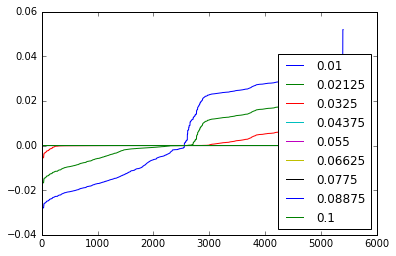

In [37]:
### GRAPHLASSO WITH SWEEP OF ALPHA VALUES

alphaSet = np.linspace(0.01,0.1, 9) # alphaSet = [0.1, 0.125, 0.15, 0.175]#, 0.2]

for myAlpha in alphaSet:
    print("For alpha=%s :"%myAlpha)
    sparseCov, sparseprec = covariance.graph_lasso(shrunk_cov, myAlpha, max_iter=500) #Run graphLasso
    plt.plot(np.sort(sparseCov.flatten())[:-74],label=str(myAlpha)) # plot all the sorted covariance entries, a sort of CDF of the covariances. We want most to be zero, and some to be positive.
    display(plotCovMap(sparseprec, myData, myNodes)) # Create a map

plt.legend(loc='top right')
Audio(filename=soundFile, autoplay=True)

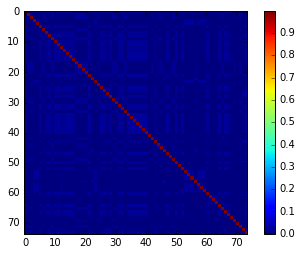

In [13]:
plt.imshow(sparseCov,interpolation='nearest')
plt.colorbar()

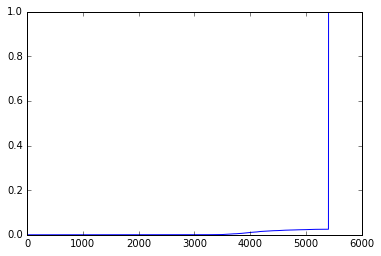

In [14]:
plt.plot(np.sort(sparseCov.flatten()))

In [19]:
### JUST THE STRONGEST LINKAGE FOR EACH NODE ###
# For each node, we find the item with the strongest covariance. 

myMap = folium.Map(location=list(np.mean([sampleSW,sampleNE],axis=0)), zoom_start=8, width=400, height=400)
maxWidth=10
# Start at row 1, go from column 2 to n 
n = myCov.shape[0]-1
myRange = np.arange(0,n)
for i in myRange:
    startNodeName = myData.index.values[i]
    myMap.circle_marker(location=[myNodes.loc[startNodeName, 'latitude'], myNodes.loc[startNodeName, 'longitude']], line_color='red', fill_color='red', )
    myCov[i,i] = 0.0

    endNodeName   = myData.index.values[myCov[i,:].argmax()]
    startLatLon = [myNodes.loc[startNodeName,'latitude'],myNodes.loc[startNodeName,'longitude']]
    endLatLon   = [myNodes.loc[ endNodeName ,'latitude'],myNodes.loc[ endNodeName ,'longitude']]
    my_PolyLine = myMap.line(locations=[startLatLon, endLatLon],line_weight= maxWidth * myCov[i,j])
myMap

/home/emunsing/.local/lib/python3.5/site-packages/ipykernel/__main__.py:11: FutureWarning: circle_marker is deprecated. Use add_children(CircleMarker) instead


NameError: name 'j' is not defined

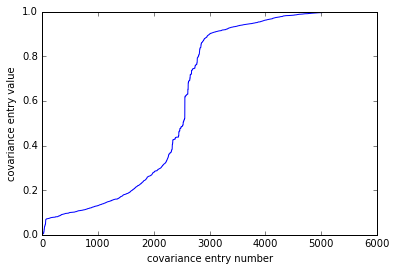

In [175]:
plt.plot(np.sort(myCov,axis=None)[n:])
plt.xlabel('covariance entry number')
plt.ylabel('covariance entry value')

# Clustering based on price traces
Would like to run different numbers of clusters, from full set to small number, and plot RMSE within the cluster for each. 

In [6]:
from sklearn import cluster
import warnings
warnings.filterwarnings('ignore', message='Changing the shape of non-C contiguous array')

uniquePriceData = pd.read_csv("Data/uniquePriceData.csv", header=0,index_col=0)

In [ ]:
# Set number of clusters
# Compute clusters and labels
# Get inertia for this set of clusters: this is the sum squared distances from each point to the center, \sum( ||x_i - u_i||_2 )
# save the value of k and the 

myData = APNode_Prices
outfileName = 'Results/kMeansResults_allData.json'

stepSize = 100
clusterCount = np.arange(,myData.shape[0],stepSize)
kMeansResults = pd.DataFrame(index=clusterCount,columns=['inertia','labels'])
clusterer = cluster.KMeans(init='k-means++', n_jobs=-1)

for k in clusterCount:
    clusterer.set_params(**{'n_clusters':k})
    clusterer.fit(myData.values.astype('float64'))
    kMeansResults.loc[k,'inertia'] = clusterer.inertia_
    kMeansResults.loc[k,'labels'] = clusterer.labels_
    kMeansResults.to_json(outfileName)
    print("Done with k=%s, inertia= %0.2f"%(k,clusterer.inertia_))
    sys.stdout.flush

Audio(filename=soundFile, autoplay=True)

Done with k=100
Done with k=200
Done with k=300
Done with k=400
Done with k=500
Done with k=600
Done with k=700
Done with k=800
Done with k=900
Done with k=1000
Done with k=1100
Done with k=1200
Done with k=1300
Done with k=1400
Done with k=1500
Done with k=1600
Done with k=1700
Done with k=1800
Done with k=1900


In [8]:
kMeansResults = pd.read_json('Results/kMeansResults_allData.json')
kMeansResults.sort_index(inplace=True)  # JSON data are not necessarily in order

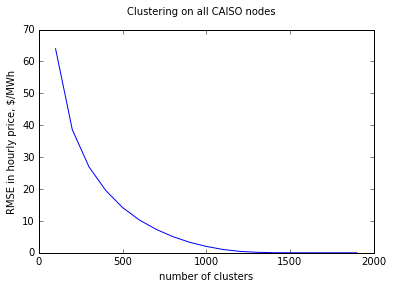

In [9]:
# Calculate RMSE for each node, and plot resulting 
kMeansResults['rmse'] = np.sqrt(kMeansResults['inertia'].values.astype('float')/(uniquePriceData.shape[1]*1.0))
plt.plot(kMeansResults.index, kMeansResults['rmse'])
plt.xlabel('number of clusters')
plt.ylabel('RMSE in hourly price, $/MWh')
plt.suptitle("Clustering on all CAISO nodes")

In [13]:
kMeansResults['rmse']

100     64.004583
200     38.605344
300     26.915452
400     19.538909
500     14.203169
600     10.306147
700      7.384925
800      5.079397
900      3.309170
1000     2.007579
1100     1.045325
1200     0.450606
1300     0.162055
1400     0.037186
1500     0.000990
1600     0.000011
1700     0.000011
1800     0.000011
1900     0.000011
2000          NaN
2100          NaN
2200          NaN
Name: rmse, dtype: float64

# Gradual expansion of clusters to identify graph

Pseudocode:
- Use *n* initializations to help ensure that we avoid local minima.
- Start with n clusters (one per node)
- Decrease to n-1 clusters.
- See which node(s) changed labels.
    - For the nodes which changed labels, identify the closest (RMSE in energy trace) node in their new cluster.
    - Draw a line between these two nodes proportional to the distance/RMSE between the two nodes.
    
Criteria:
- Need to be sure that node assignments/labels are repeatable. If labels change between runs, then this would become really annoying.

In [ ]:
# Run the clustering algorithm for k
# For i in range(k)
#  Choose all nodes which are labeled i
#  For each of these nodes,
#     create a circle at its location and label it as 

from matplotlib.pyplot import cm
colors = cm.rainbow(np.linspace(0,1,k))

for i in range(k):
    nodeNames = myNodes[clusterer.labels_ = i].index.values()
    markers = [folium.CircleMarker(location=[myNodes.loc[x, 'latitude'], myNodes.loc[x, 'longitude']], color='red', fill_color='red', )

In [44]:
for k in np.arange(5,15):

    clusterer.set_params(**{'n_clusters':k})
    clusterer.fit(X)
    myMap = folium.Map(location=list(np.mean([sampleSW,sampleNE],axis=0)), tiles='Stamen Toner', zoom_start=8, width=400, height=400)
    colors = cm.rainbow(np.linspace(0,1,k))
    for i in range(k):
        thisColor = matplotlib.colors.rgb2hex(colors[i])
        nodeNamesInLabel = myNodes[clusterer.labels_ == i].index.values
        for x in nodeNamesInLabel:
            myMap.add_child(folium.CircleMarker(location=[myNodes.loc[x, 'latitude'], myNodes.loc[x, 'longitude']],
                                       color=thisColor, fill_color=thisColor, popup=str(i)))
    print("k=%s"%k)
    display(myMap)

k=5


k=6


k=7


k=8


k=9


k=10


k=11


k=12


k=13


k=14


# Implementing GraphLassoCV as done in the "Visualizing the Stock Market" example

In [48]:
edge_model = covariance.GraphLassoCV()
edge_model.fit(X)
edge_model.alpha_

partial_correlations = edge_model.precision_.copy()
d = 1/ np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:,np.newaxis]
non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 1e-6)

In [ ]:
plt.imshow(edge_model.covariance_)
plt.colorbar()

In [ ]:
plt.imshow(edge_model.precision_)
plt.colorbar()

array([-120.84, -122.31, -121.92, -121.31, -121.23])

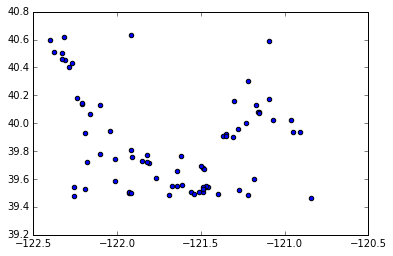

In [58]:
nodex, nodey = myNodes.loc[myData.index.values,['longitude','latitude']].values.T

In [82]:
start_idx, end_idx = np.where(non_zero)
segments = [[np.array([myNodes.loc[ myData.index[start],'longitude'],myNodes.loc[ myData.index[start],'latitude']]),
             np.array([myNodes.loc[ myData.index[stop ],'longitude'],myNodes.loc[ myData.index[stop ],'latitude']])]
            for start,stop in zip(start_idx,end_idx) ]
values = np.abs(partial_correlations[non_zero])


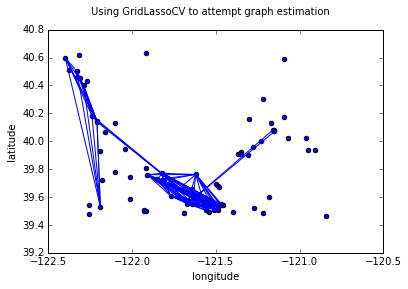

In [80]:
# ax = plt.axes()
plt.scatter(nodex,nodey)
# lc = LineCollection(segments,zorder=0, cmap=plt.cm.hot_r,norm=plt.Normalize(0,0.7*values.max()))
for start, stop in zip(start_idx, end_idx):
    plt.plot([myNodes.loc[ myData.index[start],'longitude'],myNodes.loc[ myData.index[stop],'longitude']],
             [myNodes.loc[ myData.index[start],'latitude'],myNodes.loc[ myData.index[stop],'latitude']],c='blue')
# lc.set_array(values)
# lc.set_linewidths(15*values)
# ax.add_collection(lc)
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.suptitle('Using GridLassoCV to attempt graph estimation')